In [16]:
import numpy as np
import random
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from joblib import dump

import itertools
from sklearn.utils import shuffle
from scipy import signal
%matplotlib inline


from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectFdr, chi2

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

from utils.svm import preProcess
from utils.visualize import showMe
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
signal_length = 100
resource_path = 'resources/'
train_sessions = ['session_0','session_1', 'session_2', 'session_3']
test_sessions  = ['session_0','session_1', 'session_2', 'session_3', 'session_4']

rests = []
eyebrows = []
chews = []
for session in train_sessions:
    rests.append(np.load(os.path.join(resource_path,session,'Rest.npy')))
    eyebrows.append(np.load(os.path.join(resource_path,session,'Eyebrow.npy')))
    chews.append(np.load(os.path.join(resource_path,session,'Chew.npy')))
rests = np.concatenate((rests),axis=0)
eyebrows = np.concatenate((eyebrows),axis=0)
chews = np.concatenate((chews),axis=0)



rests = preProcess(rests, signal_length)
eyebrows = preProcess(eyebrows, signal_length)
chews = preProcess(chews, signal_length)

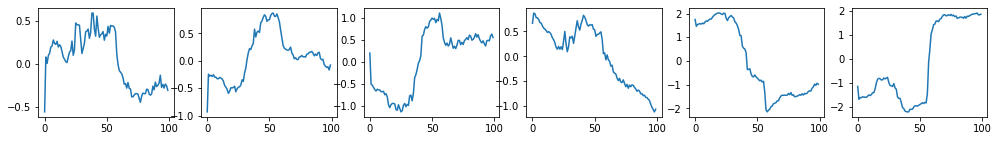

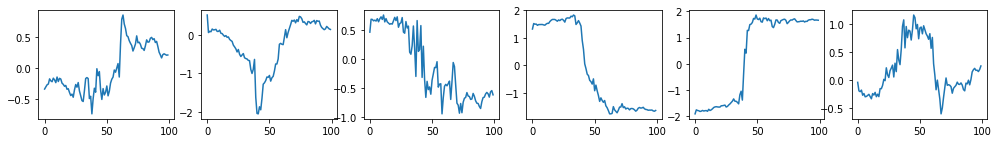

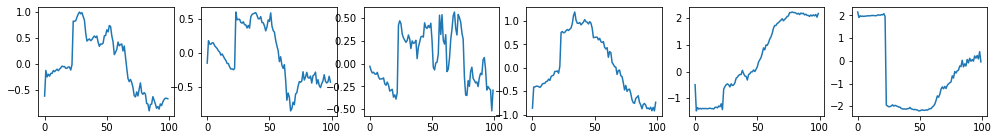

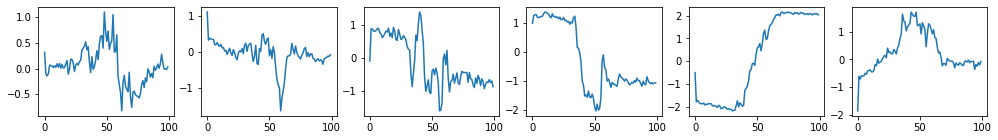

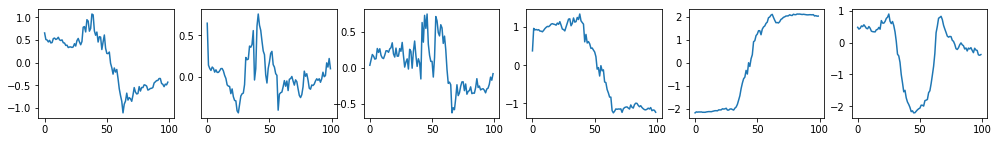

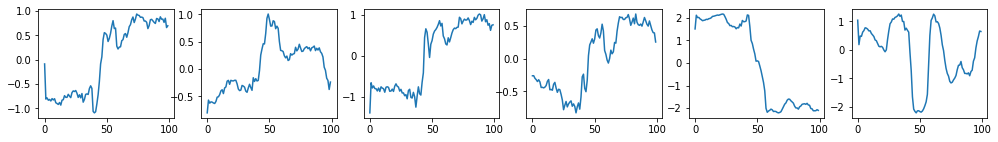

In [18]:
def showFirstN(data, limit = 5):
    i = 0
    for trial in data:
        showMe(trial)
        if i == 5:
            break
        i += 1
showFirstN(rests)

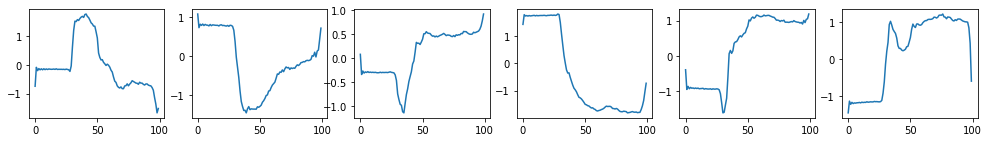

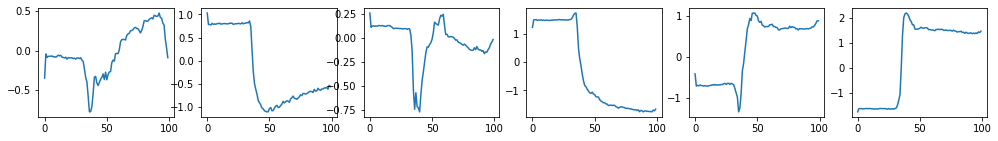

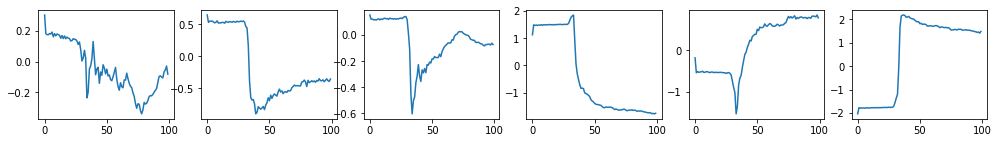

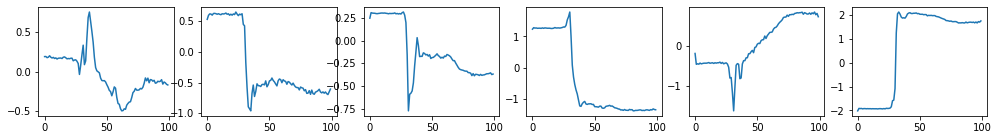

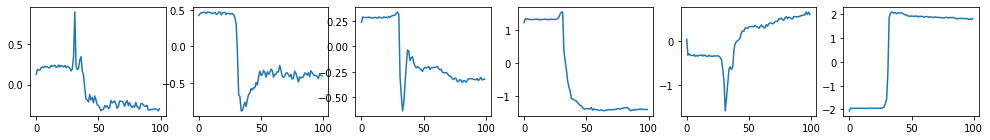

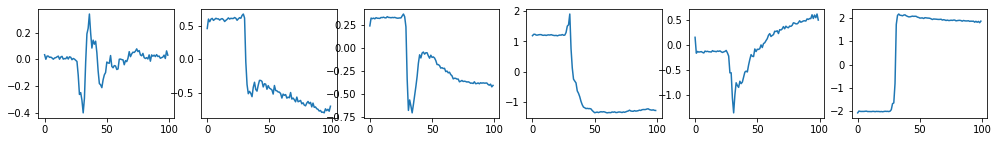

In [5]:
showFirstN(eyebrows)

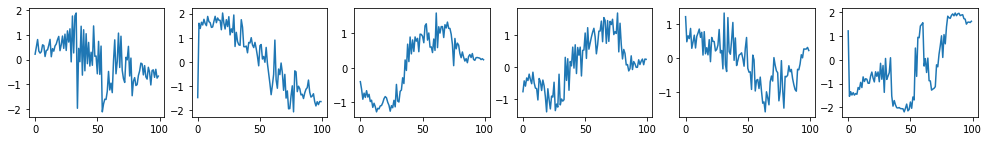

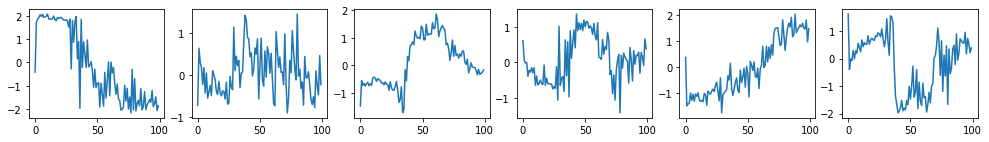

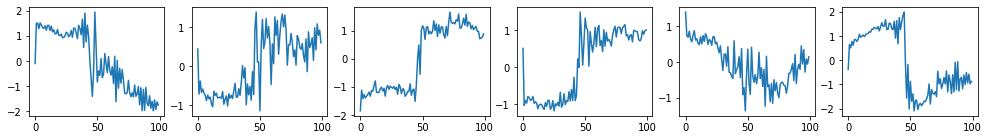

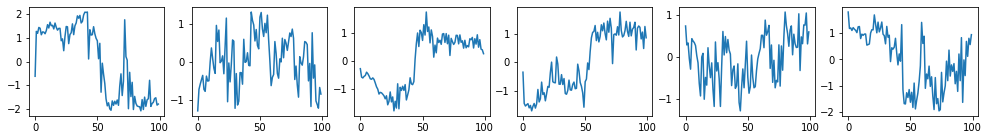

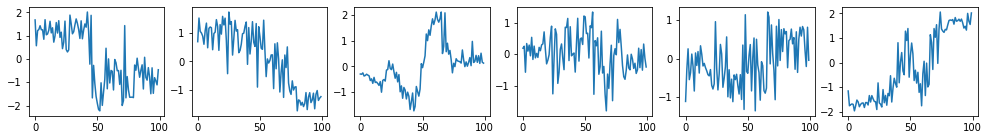

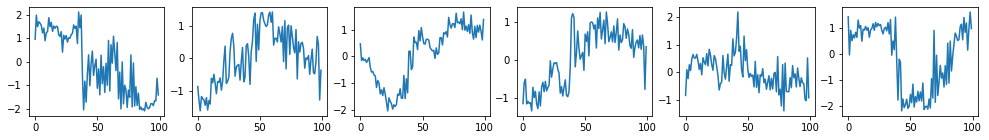

In [6]:
showFirstN(chews)

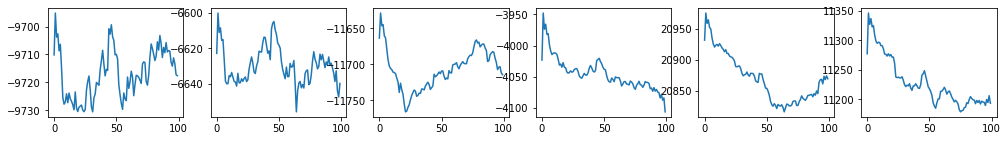

In [32]:
rests_avg = rests.mean(axis=0)
showMe(rests_avg)

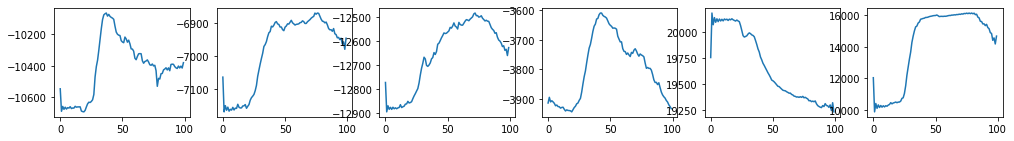

In [22]:
eyebrows_avg = eyebrows.mean(axis=0)
showMe(eyebrows_avg)

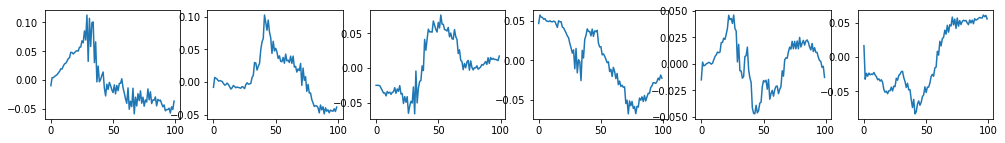

In [12]:
chews_avg = chews.mean(axis=0)
showMe(chews_avg)

In [19]:
X = np.concatenate((rests,eyebrows,chews),axis = 0)
y = np.concatenate(( np.zeros(rests.shape[0]),np.ones(eyebrows.shape[0]),np.ones(eyebrows.shape[0])*2))

c = list(zip(X, y))
random.seed(42)
random.shuffle(c)
X,y = zip(*c)


X = np.array(X).reshape(-1,6*signal_length)
y = np.array(y)

print(X.shape)
print(y.shape)

(240, 600)
(240,)


In [20]:
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100,1000], 'gamma': [10,1,0.1,0.01,0.001,0.0001]} 

In [21]:
accs = []
models = []
def grid(X_train,y_train, X_test, y_test):
    grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
    grid.fit(X_train,y_train)

    grid_predictions = grid.predict(X_test)
    acc = accuracy_score(y_test,grid_predictions)
    accs.append(acc)
    models.append(grid.best_estimator_)
    if acc > 0.9:
        return True
    else:
        return False


skf = StratifiedKFold(n_splits=10,random_state= 42, shuffle = True)
for train, test in skf.split(X, y):
    
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]

    if grid(X_train,y_train, X_test, y_test):
        break
    

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END .................................C=0.001, gamma=0.1; total time=   0.0s
[CV] END .................................C=0.0

In [22]:
model = models[accs.index(max(accs))]
for acc in accs:
    print(acc)

0.6666666666666666
0.875
0.9583333333333334


In [8]:
def evaluate(session):
    rests    = np.load(resource_path+session+'/Rest.npy')
    eyebrows = np.load(resource_path+session+'/Eyebrow.npy')
    chews    = np.load(resource_path+session+'/Chew.npy')

    rests = preProcess(rests)
    eyebrows = preProcess(eyebrows)
    chews = preProcess(chews)

    rests = rests.reshape(-1,6*signal_length)
    eyebrows = eyebrows.reshape(-1,6*signal_length)
    chews = chews.reshape(-1,6*signal_length)
    

    correct = 0
    incorrect = 0

    for r in rests:
        if abs(0-model.predict([r]))<0.5:
            correct+=1
        else:
            incorrect+=1
    
    for r in eyebrows:
        if abs(1-model.predict([r]))<0.5:
            correct+=1
        else:
            incorrect+=1
    
    for r in chews:
        if abs(2-model.predict([r]))<0.5:
            correct+=1
        else:
            incorrect+=1

            
    print('Total:{}, correct:{}, acc:{}%'.format(correct+incorrect,correct,round(correct/(correct+incorrect),2)*100))

    

In [9]:
for session in test_sessions:
    print("Evaluating session: {}".format(session))
    evaluate(session)

Evaluating session: session_0
Total:60, correct:53, acc:88.0%
Evaluating session: session_1
Total:60, correct:59, acc:98.0%
Evaluating session: session_2
Total:60, correct:59, acc:98.0%
Evaluating session: session_3
Total:60, correct:49, acc:82.0%
Evaluating session: session_4
Total:60, correct:50, acc:83.0%


In [23]:
dump(model, 'saved_models/svm_acc_95.joblib') 

['saved_models/svm_acc_95.joblib']